<a href="https://colab.research.google.com/github/vipulSharma18/Automatic-Emotion-Recognition-on-DEAP-Dataset/blob/main/models/2_level_Ensemble_of_Light_Pyramidal_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Relevant Libraries

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Softmax
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import gc
from keras.callbacks import ReduceLROnPlateau
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# GPU Check

In [ ]:
print(tf.version.VERSION)
print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

NameError: ignored

# Data Augmentation

## Load Data from .dat files into a np array of 1280 x 32 x 8064 size

In [ ]:
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/content/drive/MyDrive/major project/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :]  #indexing EEG signals from physiological data
    all_sub_data.extend(sub_eeg)
    gc.collect()
gc.collect()
all_sub_data = np.array(all_sub_data)

In [ ]:
all_sub_data.shape

(1280, 32, 8064)

## Z-score normalization of each EEG signal, resultant np.array is all_sub_data

In [ ]:
for sub in range(all_sub_data.shape[0]):
  all_sub_data[sub] = zscore(all_sub_data[sub], axis = 1)  #zscore normalize each channel
gc.collect()

22

## Label Loading into np array of 1280 x 1 named, sub_labels

In [ ]:
labels = pd.read_excel("/content/drive/MyDrive/major project/metadata/Labels.xls")
#for multiclass classification 
#sub_labels = labels["Valence-Arousal Model Quadrant"].astype('int')
#for binary classification of valence scale
sub_labels = labels["Valence Label (1=H, 0=L)"].astype('int')
gc.collect()
sub_labels


0       1
1       1
2       1
3       0
4       1
       ..
1275    0
1276    0
1277    0
1278    0
1279    1
Name: Valence Label (1=H, 0=L), Length: 1280, dtype: int64

Counter({3: 458, 1: 296, 2: 266, 0: 260})


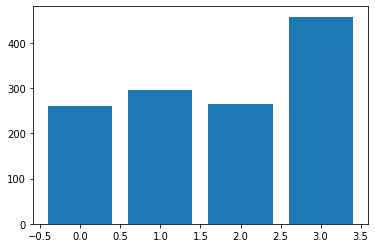

In [ ]:
#SKIP FOR BINARY CLASSIFICATION
# Add frequency bar plot here for dataset label distribution
c = Counter(sub_labels)
print(c)
plt.figure()
plt.bar([0,1,2,3], [c[0], c[1], c[2], c[3]])
plt.show()

## Label Binarization of multi-class labels  
> sub_labels: (1280,4)

In [ ]:
lb = preprocessing.LabelBinarizer()
sub_labels = lb.fit_transform(sub_labels)
print(lb.classes_)
print(sub_labels.shape)
print(sub_labels)

[0 1]
(1280, 1)
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]]


In [ ]:
sub_labels.shape

(1280,)

In [ ]:
gc.collect()

0

In [ ]:
np.unique(sub_labels, axis = 0)

array([0, 1])

## Label Binarization of 2/Binary labels  
> sub_labels: (1280,2)

In [ ]:
sub_labels.shape

(1280,)

In [ ]:
def encode(x):
  if(x==1):
    return [0,1]
  elif(x==0):
    return [1,0]
  else:
    print("invalid value")
    return None
sub_labels_bin = np.array(list(map(encode, sub_labels)))
print(sub_labels_bin.shape)
print(sub_labels_bin[:6])

(1280, 2)
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]


In [ ]:
sub_labels_bin[0]

array([0, 1])

In [ ]:
sub_labels = sub_labels_bin
gc.collect()
print(sub_labels.shape)

(1280, 2)


In [ ]:
def inv_bin(x):
  if(x == [0,1]):
     return 1
  elif(x==[1,0]):
    return 0


## Generating Train Test Splits,  
> X_train, y_train: (1152,32,8064), (1152,4)  
> X_test, y_test: (128,32,8064), (128,4)  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_sub_data, sub_labels, test_size = 0.1, random_state = 42,shuffle = True, stratify = sub_labels)
#TO DO:
#Check if class imbalance in the splits exists and is severe than the dataset
#use stratify = y_labels to ensure same distribution as dataset

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1152, 32, 8064), (1152, 2), (128, 32, 8064), (128, 2))

## Verifying Frequency distribution of labels
(Skip for Binary Classification)

labels in train [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
label in test [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
Counter({3: 412, 1: 266, 2: 240, 0: 234})


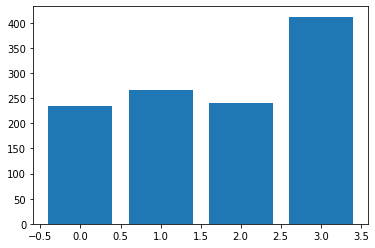

In [ ]:
#Check frequency distribution of classes in training and testing splits
# use LabelBinarizer.inverse_transform(y_train) to obtain labels in [0,1,2,3] 
print("labels in train",np.unique(y_train, axis = 0))
print("label in test",np.unique(y_test, axis= 0))
c_train = Counter(lb.inverse_transform(y_train))
print(c_train)
plt.figure()
plt.bar([0,1,2,3], [c_train[0], c_train[1], c_train[2], c_train[3]])
plt.show()


Counter({3: 46, 1: 30, 2: 26, 0: 26})


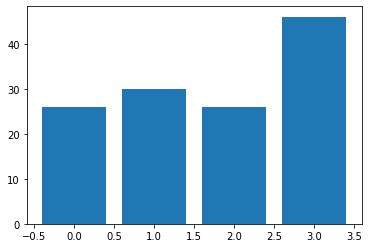

In [ ]:

c_test = Counter(lb.inverse_transform(y_test))
print(c_test)
plt.figure()
plt.bar([0,1,2,3], [c_test[0], c_test[1], c_test[2], c_test[3]])
plt.show()

In [ ]:
for i in [0,1,2,3]:
  print(c_train[i]/1152, c_test[i]/128, c[i]/1280, end = ' | ')
print("\nThe distribution of labels is maintained")

0.203125 0.203125 0.203125 | 0.2309027777777778 0.234375 0.23125 | 0.20833333333333334 0.203125 0.2078125 | 0.3576388888888889 0.359375 0.3578125 | 
The distribution of labels is maintained


In [ ]:
try:
  del all_sub_data
  del sub_labels
  del labels
  del x
  del sub_data
  del sub_eeg
  del subjects_list
except:
  pass
gc.collect()

334

## Repetition of Labels for Windowing of training data  

> y_train_12, y_train_6, y_train_4 of shapes(?,4): 13824, 6912 and 4608 respectively 


In [ ]:
y_train = np.array(y_train)
print(y_train.shape, type(y_train))

(1152, 2) <class 'numpy.ndarray'>


In [ ]:
#12,6 and 4 subsignals are generated from 8064 length EEG signal, labels repeated accordingly
y_train_12 = np.repeat(y_train, 12, axis = 0)
y_train_6 = np.repeat(y_train, 6, axis = 0)
y_train_4 = np.repeat(y_train, 4, axis = 0)
del(y_train)
gc.collect()
print(y_train_12.shape, y_train_6.shape, y_train_4.shape)

(13824, 2) (6912, 2) (4608, 2)


In [ ]:
if(input("Enter 'y' to focus on 12 windows:") == 'y'):
  try:
    del y_train_6, y_train_4
  except:
    pass
gc.collect()

Enter 'y' to focus on 12 windows:y


79

Counter({3: 4944, 1: 3192, 2: 2880, 0: 2808})
0.203125 0.203125 0.203125 | 0.2309027777777778 0.2309027777777778 0.23125 | 0.20833333333333334 0.20833333333333334 0.2078125 | 0.3576388888888889 0.3576388888888889 0.3578125 | 
The distribution of labels is maintained


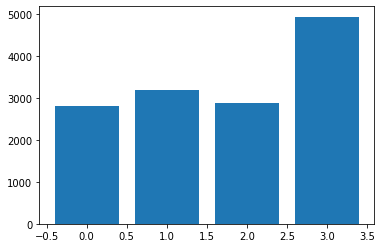

In [ ]:
#SKIP FOR BINARY CLASSIFICATION
#Frequency distribution of the repeated labels
c_train_12 = Counter(lb.inverse_transform(y_train_12))
print(c_train_12)
for i in [0,1,2,3]:
  print(c_train[i]/1152, c_train_12[i]/13824, c[i]/1280, end = ' | ')
print("\nThe distribution of labels is maintained")
plt.figure()
plt.bar([0,1,2,3], [c_train_12[0], c_train_12[1], c_train_12[2], c_train_12[3]])
plt.show()

In [ ]:
try:
  del c_train, c_test, c_train_12, c
except:
  pass
gc.collect()

60

## Loading Training data with different window sizes

In [ ]:
channel_wise = np.transpose(X_train, (1,0,2))

In [ ]:
del(X_train)
gc.collect()
def process_input(instances, sub_signals):
  #instances must be channel wise of shape (32, -1, 8064)
  samples = int(8064/sub_signals)
  transformed = []
  for i in range(instances.shape[0]):
    transformed.append(np.reshape(instances[i], (-1,samples,1)))
  transformed = np.array(transformed)
  print(transformed.shape, 'is the shape obtained.')
  gc.collect()
  return transformed

### 12 sub signals of length 672 each, total 13824 instances

In [ ]:
#X_train_12 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_12.npy")
#print(X_train_12.shape, 'Shape of Training Data')
X_train_12 = process_input(channel_wise, 12)
gc.collect()

(32, 13824, 672, 1) is the shape obtained.


0

### 6 sub signals of length 1344 each, total 6912 instances

In [ ]:
#X_train_6 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_6.npy")
#print(X_train_6.shape, 'Shape of Training Data')
#gc.collect()

### 4 sub signals of length 2016 each, total 4608 instances

In [ ]:
#X_train_4 = np.load("/content/drive/MyDrive/major project/data_augmentation/channel_wise_4.npy")
#print(X_train_4.shape, 'Shape of Training Data')
#gc.collect()

In [ ]:
gc.collect()

0

Free Up ram

In [ ]:
del channel_wise
gc.collect()

0

# Lightweight Pyramidal 1D CNN model

## Helper Functions for plotting, confusion matrix etc.

In [ ]:
def plot_evaluation_curves(history, EPOCHS, metrics = ('accuracy', 'val_accuracy')):
  acc = history.history[metrics[0]]
  val_acc = history.history[metrics[1]]

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training ' + metrics[0])
  plt.plot(epochs_range, val_acc, label='Validation '+ metrics[0])
  plt.legend(loc='lower right')
  plt.title('Training and Validation ' + + metrics[0])

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
gc.collect()

0

### Checking the distribution of predicted labels to check if majority class voting being done or Model is actually learning
 

In [ ]:
def show_metrics(x_train, x_val, y_train, y_val, model):
  print("TRAINING MEASURES: ")
  #Training Data metrics
  pred_y = model.predict(x_train)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution of Training Dataset")
  c_true = Counter(np.argmax(y_train, axis = 1))
  print(c_true, "Actual Distribution of Training Dataset")
  print(model.evaluate(x_train, y_train), "Training Accuracy of Model.")
  print("Classification Report of Model on Training Data")
  print(classification_report(np.argmax(y_train, axis =1), np.argmax(model.predict(x_train), axis = 1) , digits = 4) )
  make_confusion_matrix(confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(model.predict(x_train), axis = 1)))
  print("\n------------------------------------------------------------------------------------------\n")

  #Validation Data Metrics
  print("VALIDATION MEASURES: ")
  pred_y = model.predict(x_val)
  c_pred = Counter(np.argmax(pred_y, axis = 1))
  print(c_pred, "Predicted Distribution of Validation Dataset")
  c_true = Counter(np.argmax(y_val, axis = 1))
  print(c_true, "Actual Distribution of Validation Dataset")
  print(model.evaluate(x_val, y_val), "Validation Accuracy of Model.")
  print("Classification Report of Model on Validation Data")
  print(classification_report(np.argmax(y_val, axis = 1), np.argmax(model.predict(x_val), axis = 1), digits = 4))
  make_confusion_matrix(confusion_matrix(np.argmax(y_val, axis = 1), np.argmax(model.predict(x_val), axis =1)) )
  print("\n------------------------------------------------------------------------------------------\n")
  gc.collect()

## Model Architecture Function

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [ ]:
def dummy_models(sub_signals=12, metrics = METRICS):
  sample_size = int(8064/sub_signals)
  models = [0]*32
  for i in range(32):
    models[i] = Sequential()
    models[i].add(Dense(500, activation = 'relu', input_shape = (sample_size, 1)))
    models[i].add(Dense(220, activation = 'relu'))
    models[i].add(Dense(100, activation = 'relu'))
    models[i].add(Dense(40, activation = 'relu'))
    models[i].add(Dense(2,  activation = 'softmax', bias_initializer = output_bias))
    models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4) , loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)
  print("All models defined.")
  return models

In [ ]:
null_Data = np.zeros((13824, 672, 1))

In [ ]:
def create_models(dense_par=20, sub_signals=12, metrics = METRICS):
  sample_size = int(8064/sub_signals)
  models = [0]*32
  for i in range(32):
    models[i] = Sequential()
    #block 1
    models[i].add(Conv1D(filters=32, kernel_size=5,strides = 3, input_shape=(sample_size, 1)))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 2
    models[i].add(Conv1D(filters=24, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 3
    models[i].add(Conv1D(filters=16, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #block 4
    models[i].add(Conv1D(filters=8, kernel_size=3,strides = 2))
    models[i].add(BatchNormalization())
    models[i].add(tf.keras.layers.Activation('relu'))
    
    #fc-1
    models[i].add(Flatten())
    models[i].add(Dense(dense_par, activation='relu'))
    
    #dropout
    models[i].add(Dropout(rate = 0.5))
    
    #fc2 and softmax
    #binary classification
    models[i].add(Dense(2,  activation = 'softmax', bias_initializer = output_bias))
    models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4) , loss = tf.keras.losses.BinaryCrossentropy(), metrics= metrics)

    #mutliclass classification
    #models[i].add(Dense(4, activation = 'softmax'))
    #models[i].compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001) , loss = tf.keras.losses.CategoricalCrossentropy(), metrics= 'accuracy')

  print("All models defined.")
  return models

## Training using 12 sub_signals per EEG signal

In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Variables already freed


0

Input Independent Baseline model

In [ ]:
baseline_models = create_models(dense_par=20, sub_signals = 12, METRICS)
history = [0]*32
epochs = 200
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  #Null Data generation
  x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  #Input Independent Baseline
  history[j] = baseline_models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  gc.collect()
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Input Dependent Baseline Model

In [ ]:
baseline_models = create_models(dense_par=20, sub_signals = 12, METRICS)
history = [0]*32
epochs = 400
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)

  #Input Dependent dummy model
  history[j] = baseline_models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  gc.collect()
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

Input Independent LP 1DCNN model

In [ ]:
models = dummy_models(sub_signals = 12, METRICS)
history = [0]*32
epochs = 200
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  #Null Data generation
  x_train, x_val, y_train, y_val = train_test_split( null_data,y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  gc.collect()
gc.collect()


In [ ]:
# Fresh Start to training with freeing up of RAM
try:
  del models
  del history
except:
  print("Variables already freed")
gc.collect()

LP 1DCNN Input Dependent

In [ ]:
models = dummy_models(sub_signals = 12, METRICS)
history = [0]*32
epochs = 500
#range will be 32 in actual code
for j in range(1):
  print(f'Individual Net : {j+1}')   
  x_train, x_val, y_train, y_val = train_test_split( X_train_12[j],y_train_12, test_size = 0.1, random_state = 42, shuffle = True, stratify = y_train_12)
  #Actual Model Training with real data
  history[j] = models[j].fit(x_train, y_train, batch_size = 2048, epochs = epochs, validation_data = (x_val, y_val), shuffle = True, verbose = 0)
  
  show_metrics(x_train, x_val, y_train, y_val, models[j])
  plot_evaluation_curves(history[j], epochs, ('accuracy', 'val_accuracy'))
  plot_evaluation_curves(history[j], epochs, ('precision', 'val_precision'))
  plot_evaluation_curves(history[j], epochs, ('recall', 'val_recall'))
  plot_evaluation_curves(history[j], epochs, ('auc', 'val_auc'))
  print("\n-----------------------------------------------------------------------------------------")
  gc.collect()
gc.collect()


### Visualizing output of model on Training Data

Binary Classification Model

In [ ]:
y_train_pred = np.argmax(models[0].predict(x_train), axis =1 )
y_val_pred = np.argmax(models[0].predict(x_val), axis =1 )
y_train_12_pred = np.argmax(models[0].predict(X_train_12[0]), axis =1 )
print("Shape of Predictions", y_train_pred.shape, y_val_pred.shape, y_train_12_pred.shape)
print("Unique Values in true labels:")
print('y_train_12\n', np.unique(y_train_12, axis = 0))
print('y_train\n', np.unique(y_train, axis = 0))
print('y_val\n', np.unique(y_val, axis = 0))

print("y_val")
c = Counter(np.argmax(y_val, axis = 1))
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print("y_val_pred")
c = Counter(y_val_pred)
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print(models[0].evaluate(x_val, y_val))

print("y_train")
c = Counter(np.argmax(y_train, axis = 1))
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print("y_train_pred")
c = Counter(y_train_pred)
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print(models[0].evaluate(x_train, y_train))


print("y_train_12")
c = Counter(np.argmax(y_train_12, axis = 1))
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print("y_train_12_pred")
c = Counter(y_train_12_pred)
total = c[0] + c[1]
print(c, c[0]/total, c[1]/total)
print(models[0].evaluate(X_train_12[0], y_train_12))


Unique Values in true labels:
y_train_12
 [[0 1]
 [1 0]]
y_train
 [[0 1]
 [1 0]]
y_val
 [[0 1]
 [1 0]]
y_val
Counter({1: 783, 0: 600}) 0.43383947939262474 0.5661605206073753
y_train
Counter({1: 7041, 0: 5400}) 0.4340487099107789 0.5659512900892211
y_train_12
Counter({1: 7824, 0: 6000}) 0.4340277777777778 0.5659722222222222


## Problem of Class imbalance:  
The model is biased towards a class due to class imbalance and is not fitting the data. The class {3} is majority class with around 35% samples in train, test and original dataset
due to stratified sampling. The model accuracy is also around 35% which clearly indicated majority voting is being done and no learning. Further we created a confusion matrix for training and validation sets which confirms this hypothesis.

Solutions:
1. Use class weighing in model.fit, weightI = total/Instances_I, inverse frequency or n_samples / (n_classes * np.bincount(y))
2. Undersampling: `from sklearn.utils import resample  
no_claim_downsampled = resample(no_claim,replace = False,n_samples = len(claim), random_state = RANDOM_SEED)`    
3. Oversampling:  `claim_upsampled = resample(claim, replace=True, n_samples=len(no_claim), random_state=RANDOM_SEED)`  
4. Synthetic Sample Generation with SMOTE:   
` from imblearn.over_sampling import SMOTE  
sm = SMOTE(random_state=RANDOM_SEED, ratio=1.0)  
X_train, y_train = sm.fit_sample(X_train, y_train)`  
5. Metrics: Precision is the percentage of predicted positives that were correctly classified.  
Recall is the percentage of actual positives that were correctly classified.  
AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.  



## Preprocessing for passing test data into CNN

In [ ]:
def process_input_ensemble(instances, sub_signals):
  #instances must be channel wise of shape (-1, 32, 8064)
  gc.collect()
  samples = int(8064/sub_signals)
  transformed = []
  for i in range(instances.shape[0]):
    transformed.append(np.reshape(instances[i], (-1,sub_signals,samples,1)))
    gc.collect()
  transformed = np.array(transformed)
  print(transformed.shape, 'is the shape obtained.')
  gc.collect()
  #output shape will be (len(intances), 32, sub_signals, samples, 1)
  return transformed

## Testing Algorithm:

In [ ]:
#loop over test instances i.e. 128
  #loop over 32 channels i.e. 1 model for each channel
    #for each channel, pass the shape (sub_singals,samples,1) to M(i), here sub_signals will be the batch_size
    #get all predictions for a single channel's all samples, take their mode. This is the prediction for that channel
    #store all the channels' predicitions in an array
  #take mode for all channels' predictions from array, this is the predicted value for that instance